In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 1. Feature Preperation

In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Utilitarian_Final_Cleaned.csv'
df = pd.read_csv(file_path)

In [3]:
# Create a new column 'helpful' based on reviews being helfpul or not helpful
df['helpful'] = (df['helpful_vote'] > 0).astype(int)

In [4]:
# Define features and target
features = ['RewExt','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
                      'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE','RatingC']
target = 'helpful'



# Initialize X and y
X = df[features]
y = df[target]

# Initialize ColumnTransformer for scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), features)  # Scale numerical features
    ],
    remainder='passthrough'  # Keep all other columns in the DataFrame
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Convert the transformed data back to a DataFrame
X = pd.DataFrame(X_preprocessed, columns=features)


# 2 Train/Test Split with Stratified K-Fold Cross-validation for Unbalanced Dataset

In [5]:
## Perform stratified K-fold cross-validation for classification with a combined stratification column 'stratify' to ensure balanced class distribution in each fold
# This column is created by combining 'helpful' and 'Prod' columns as strings.
# It uses StratifiedKFold with 10 splits, ensuring each fold preserves the percentage of samples for each class label (product and helpfulness).

from sklearn.model_selection import StratifiedKFold

# Create a combined column for stratification
df['stratify'] = df['helpful'].astype(str) + "_" + df['Prod'].astype(str)

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

stratify = df['stratify']

# Splitting the data
for train_index, test_index in skf.split(X, stratify):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Print the shapes of the resulting splits to check
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    # Optionally, you can check the distribution in each split
    print("Train stratify distribution:\n", y_train.value_counts(normalize=True))
    print("Test stratify distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (16338, 15)
X_test shape: (1816, 15)
y_train shape: (16338,)
y_test shape: (1816,)
Train stratify distribution:
 helpful
0    0.840678
1    0.159322
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.840308
1    0.159692
Name: proportion, dtype: float64
X_train shape: (16338, 15)
X_test shape: (1816, 15)
y_train shape: (16338,)
y_test shape: (1816,)
Train stratify distribution:
 helpful
0    0.840617
1    0.159383
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.840859
1    0.159141
Name: proportion, dtype: float64
X_train shape: (16338, 15)
X_test shape: (1816, 15)
y_train shape: (16338,)
y_test shape: (1816,)
Train stratify distribution:
 helpful
0    0.840678
1    0.159322
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.840308
1    0.159692
Name: proportion, dtype: float64
X_train shape: (16338, 15)
X_test shape: (1816, 15)
y_train shape: (16338,)
y_test shape: (1816,)
Train stratify di

## 2.1 Data Augmentation 

In [6]:
# Applying SMOTE to the training data to ensure balanced class distribution

from imblearn.over_sampling import SMOTE

# Apply SMOTE to X_train and y_train
smote = SMOTE(random_state=42,sampling_strategy={1: 8000})
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


# Check the class distribution before resampling
print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())

# Check the class distribution after resampling
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Class distribution before SMOTE:
helpful
0    13736
1     2603
Name: count, dtype: int64
Class distribution after SMOTE:
helpful
0    13736
1     8000
Name: count, dtype: int64


# 3. Model Building 

## 3.1 Logistic Regression

In [7]:
#Using Logistic Regression as Baseline Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Initialize the logistic regression model
logreg_model = LogisticRegression(solver='sag', max_iter=1000)  # You can adjust max_iter as needed

# Train the model
logreg_model.fit(X_train_balanced, y_train_balanced)

# Predict on the testing set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
print("\nLogistic Regression Model Evaluation:")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['Logistic Regression'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

LR_results = pd.DataFrame(results_dict)


Logistic Regression Model Evaluation:
Accuracy: 0.7779614325068871
F1 Score: 0.41678726483357453
AUC: 0.6640135669869983
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1525
           1       0.36      0.50      0.42       290

    accuracy                           0.78      1815
   macro avg       0.63      0.66      0.64      1815
weighted avg       0.81      0.78      0.79      1815

[[1268  257]
 [ 146  144]]


## 3.2 Random Forest

In [8]:
# Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

# Initialize the logistic regression model
RF_model = RandomForestClassifier()  # You can adjust max_iter as needed

# Train the model
RF_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = RF_model.predict(X_test)


print("\nRandom Forest Model Evaluation:")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)





Random Forest Model Evaluation:
Accuracy: 0.8683195592286501
F1 Score: 0.4213075060532688
AUC: 0.6381967213114754
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1525
           1       0.71      0.30      0.42       290

    accuracy                           0.87      1815
   macro avg       0.79      0.64      0.67      1815
weighted avg       0.85      0.87      0.85      1815

[[1489   36]
 [ 203   87]]


## 3.2 Extreme Gradient Boosting

In [9]:
# Starting of with unbalanced data (No SMOTE applied) to evaluate improvement due to SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Train model with default hyperparameters
xgb_cls_default = xgb.XGBClassifier()

xgb_cls_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_cls_default.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault XGBoost Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_default, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost Default'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_Default_results = pd.DataFrame(results_dict)



Default XGBoost Evaluation:
Accuracy: 0.8672176308539945
F1 Score: 0.4883227176220807
AUC: 0.6766365178066704
Confusion Matrix:
[[1459   66]
 [ 175  115]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1525
           1       0.64      0.40      0.49       290

    accuracy                           0.87      1815
   macro avg       0.76      0.68      0.71      1815
weighted avg       0.85      0.87      0.85      1815

Mean Cross-Validated Accuracy: 0.8105782239141537


In [10]:
# Train model with SMOTE balanced data
xgb_cls_SMOTE = xgb.XGBClassifier()

xgb_cls_SMOTE.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_SMOTE = xgb_cls_SMOTE.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_SMOTE)
conf_matrix = confusion_matrix(y_test, y_pred_SMOTE)
cls_report = classification_report(y_test, y_pred_SMOTE)

print("\SMOTE Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_SMOTE)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_SMOTE)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_SMOTE, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost SMOTE'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_results = pd.DataFrame(results_dict)

\SMOTE Model Evaluation:
Accuracy: 0.8666666666666667
F1 Score: 0.5310077519379844
AUC: 0.7070265686828716
Confusion Matrix:
[[1436   89]
 [ 153  137]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1525
           1       0.61      0.47      0.53       290

    accuracy                           0.87      1815
   macro avg       0.75      0.71      0.73      1815
weighted avg       0.86      0.87      0.86      1815

Mean Cross-Validated Accuracy: 0.7800967008938691


### 3.2.1 XGradBoost Hyperparameter Tuning

In [11]:
# import packages for hyperparameters tuning with hyperopt (Bayesian Optimization)

# Define Search Space for hyperparameters
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 20, 1),
        'gamma': hp.uniform ('gamma', 0,5),
        'reg_lambda' : hp.uniform('reg_lambda', 0,10),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,1),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
        'seed': 0
    }

# Define the objective function, objective function: Takes space as input (hyperparameters to optimize). Returns loss to minimize
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    gamma = int(space['gamma']),
                    reg_lambda = int(space['reg_lambda']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=(space['colsample_bytree']))
    
    evaluation = [( X_train_balanced, y_train_balanced), ( X_test, y_test)]
    
    clf.fit(X_train_balanced, y_train_balanced,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [12]:
# Running Bayesian Optimization

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                 
0.8672176308539945                                     
  0%|          | 1/200 [00:00<00:32,  6.20trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8639118457300275                                                                
  1%|          | 2/200 [00:00<00:26,  7.44trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.846831955922865                                                                 
SCORE:                                                                            
0.8606060606060606                                                                
  2%|▏         | 4/200 [00:00<00:34,  5.73trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8589531680440772                                                                
  2%|▎         | 5/200 [00:00<00:42,  4.63trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.865564738292011                                                                 
  3%|▎         | 6/200 [00:01<00:43,  4.45trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8606060606060606                                                                
SCORE:                                                                            
0.8545454545454545                                                                
  4%|▍         | 8/200 [00:01<00:48,  3.93trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8545454545454545                                                                
SCORE:                                                                            
0.8534435261707989                                                                
  5%|▌         | 10/200 [00:02<00:39,  4.87trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8578512396694215                                                                 
SCORE:                                                                             
0.8528925619834711                                                                 
  6%|▌         | 12/200 [00:02<00:33,  5.57trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8584022038567493                                                                 
SCORE:                                                                             
0.8545454545454545                                                                 
  7%|▋         | 14/200 [00:02<00:28,  6.57trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8539944903581267                                                                 
  8%|▊         | 15/200 [00:02<00:29,  6.18trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8589531680440772                                                                 
  8%|▊         | 16/200 [00:03<00:33,  5.44trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8606060606060606                                                                 
  8%|▊         | 17/200 [00:03<00:35,  5.21trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8578512396694215                                                                 
SCORE:                                                                             
0.8567493112947658                                                                 
 10%|▉         | 19/200 [00:03<00:34,  5.32trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8550964187327824                                                                 
SCORE:                                                                             
0.8622589531680441                                                                 
 10%|█         | 21/200 [00:04<00:31,  5.65trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8661157024793389                                                                 
 11%|█         | 22/200 [00:04<00:34,  5.11trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8666666666666667                                                                 
SCORE:                                                                             
0.8633608815426997                                                                 
 12%|█▏        | 24/200 [00:04<00:36,  4.85trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8578512396694215                                                                 
SCORE:                                                                             
0.8600550964187328                                                                 
 13%|█▎        | 26/200 [00:05<00:28,  6.10trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8606060606060606                                                                 
SCORE:                                                                             
0.856198347107438                                                                  
 14%|█▍        | 28/200 [00:05<00:30,  5.62trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8578512396694215                                                                 
SCORE:                                                                             
0.8556473829201102                                                                 
 15%|█▌        | 30/200 [00:05<00:32,  5.16trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8628099173553719                                                                 
 16%|█▌        | 31/200 [00:06<00:30,  5.46trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8584022038567493                                                                 
 16%|█▌        | 32/200 [00:06<00:36,  4.61trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8501377410468319                                                                 
 16%|█▋        | 33/200 [00:06<00:36,  4.57trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.859504132231405                                                                  
SCORE:                                                                             
0.8556473829201102                                                                 
 18%|█▊        | 35/200 [00:07<00:36,  4.54trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8584022038567493                                                                 
 18%|█▊        | 36/200 [00:07<00:38,  4.24trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8633608815426997                                                                 
SCORE:                                                                             
0.8512396694214877                                                                 
 19%|█▉        | 38/200 [00:07<00:37,  4.28trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.859504132231405                                                                  
 20%|█▉        | 39/200 [00:08<00:55,  2.92trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8617079889807162                                                                 
 20%|██        | 40/200 [00:08<00:54,  2.95trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8611570247933884                                                                 
 20%|██        | 41/200 [00:09<00:58,  2.72trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.865564738292011                                                                  
 21%|██        | 42/200 [00:09<00:52,  3.04trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8600550964187328                                                                 
SCORE:                                                                             
0.8545454545454545                                                                 
 22%|██▏       | 44/200 [00:09<00:42,  3.66trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8628099173553719                                                                 
 22%|██▎       | 45/200 [00:10<00:45,  3.37trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8539944903581267                                                                 
SCORE:                                                                             
0.8275482093663912                                                                 
 24%|██▎       | 47/200 [00:10<00:42,  3.63trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8512396694214877                                                                 
SCORE:                                                                             
0.8391184573002755                                                                 
 24%|██▍       | 49/200 [00:11<00:35,  4.24trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8512396694214877                                                                 
 25%|██▌       | 50/200 [00:11<00:30,  4.85trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8650137741046832                                                                 
SCORE:                                                                             
0.8573002754820936                                                                 
 26%|██▌       | 51/200 [00:11<00:32,  4.52trial/s, best loss: -0.8672176308539945]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8462809917355372                                                                 
SCORE:                                                                             
0.8677685950413223                                                                 
 27%|██▋       | 54/200 [00:11<00:23,  6.17trial/s, best loss: -0.8677685950413223]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8550964187327824                                                                 
SCORE:                                                                             
0.8534435261707989                                                                 
 28%|██▊       | 56/200 [00:12<00:21,  6.70trial/s, best loss: -0.8677685950413223]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8573002754820936                                                                 
 28%|██▊       | 57/200 [00:12<00:19,  7.37trial/s, best loss: -0.8677685950413223]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.856198347107438                                                                  
SCORE:                                                                             
0.8539944903581267                                                                 
 30%|██▉       | 59/200 [00:12<00:21,  6.43trial/s, best loss: -0.8677685950413223]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8556473829201102                                                                 
SCORE:                                                                             
0.8484848484848485                                                                 
 30%|███       | 60/200 [00:12<00:20,  6.96trial/s, best loss: -0.8677685950413223]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.856198347107438                                                                  
SCORE:                                                                             
0.8550964187327824                                                                 
 32%|███▏      | 63/200 [00:13<00:19,  7.19trial/s, best loss: -0.8677685950413223]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.859504132231405                                                                  
SCORE:                                                                             
0.8567493112947658                                                                 
 32%|███▎      | 65/200 [00:13<00:20,  6.62trial/s, best loss: -0.8677685950413223]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8650137741046832                                                                 
SCORE:                                                                             
0.8705234159779615                                                                 
 34%|███▎      | 67/200 [00:13<00:24,  5.49trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8644628099173554                                                                 
SCORE:                                                                             
0.8628099173553719                                                                 
 34%|███▍      | 69/200 [00:14<00:22,  5.71trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8584022038567493                                                                 
 35%|███▌      | 70/200 [00:14<00:21,  6.11trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8600550964187328                                                                 
SCORE:                                                                             
0.856198347107438                                                                  
 36%|███▌      | 72/200 [00:14<00:21,  5.95trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8611570247933884                                                                 
SCORE:                                                                             
0.8633608815426997                                                                 
 37%|███▋      | 74/200 [00:14<00:18,  6.64trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8517906336088155                                                                 
SCORE:                                                                             
0.8639118457300275                                                                 
 38%|███▊      | 76/200 [00:15<00:17,  7.13trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8528925619834711                                                                 
SCORE:                                                                             
0.8611570247933884                                                                 
 39%|███▉      | 78/200 [00:15<00:15,  7.78trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8633608815426997                                                                 
SCORE:                                                                             
0.8688705234159779                                                                 
 40%|████      | 80/200 [00:15<00:15,  7.59trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8600550964187328                                                                 
SCORE:                                                                             
0.8567493112947658                                                                 
 41%|████      | 82/200 [00:15<00:15,  7.64trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8617079889807162                                                                 
SCORE:                                                                             
0.8606060606060606                                                                 
 42%|████▏     | 84/200 [00:16<00:16,  7.19trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8567493112947658                                                                 
SCORE:                                                                             
0.8584022038567493                                                                 
 43%|████▎     | 86/200 [00:16<00:16,  6.72trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8556473829201102                                                                 
SCORE:                                                                             
0.8501377410468319                                                                 
 44%|████▍     | 88/200 [00:16<00:15,  7.25trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8501377410468319                                                                 
SCORE:                                                                             
0.8600550964187328                                                                 
 45%|████▌     | 90/200 [00:17<00:15,  7.10trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8611570247933884                                                                 
SCORE:                                                                             
0.8528925619834711                                                                 
 46%|████▌     | 92/200 [00:17<00:14,  7.52trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8578512396694215                                                                 
SCORE:                                                                             
0.8584022038567493                                                                 
 47%|████▋     | 94/200 [00:17<00:15,  6.91trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8639118457300275                                                                 
SCORE:                                                                             
0.856198347107438                                                                  
SCORE:                                                                             
0.8545454545454545                                                                 
 48%|████▊     | 97/200 [00:18<00:13,  7.48trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8600550964187328                                                                 
 49%|████▉     | 98/200 [00:18<00:12,  7.96trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8528925619834711                                                                 
SCORE:                                                                             
0.8606060606060606                                                                 
 50%|█████     | 100/200 [00:18<00:13,  7.36trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.856198347107438                                                                   
SCORE:                                                                              
0.8451790633608816                                                                  
 51%|█████     | 102/200 [00:18<00:12,  7.81trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8584022038567493                                                                  
SCORE:                                                                              
0.8573002754820936                                                                  
 52%|█████▏    | 104/200 [00:19<00:13,  7.37trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8534435261707989                                                                  
SCORE:                                                                              
0.8512396694214877                                                                  
 53%|█████▎    | 106/200 [00:19<00:13,  7.03trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8672176308539945                                                                  
SCORE:                                                                              
0.8545454545454545                                                                  
 54%|█████▍    | 108/200 [00:19<00:13,  6.81trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8633608815426997                                                                  
SCORE:                                                                              
0.8545454545454545                                                                  
 55%|█████▌    | 110/200 [00:19<00:12,  7.01trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8578512396694215                                                                  
SCORE:                                                                              
0.8589531680440772                                                                  
 56%|█████▌    | 112/200 [00:20<00:12,  7.03trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8573002754820936                                                                  
SCORE:                                                                              
0.8506887052341597                                                                  
 57%|█████▋    | 114/200 [00:20<00:11,  7.58trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8517906336088155                                                                  
SCORE:                                                                              
0.8617079889807162                                                                  
 58%|█████▊    | 116/200 [00:20<00:12,  6.79trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8617079889807162                                                                  
SCORE:                                                                              
0.8606060606060606                                                                  
 59%|█████▉    | 118/200 [00:21<00:10,  7.58trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8523415977961433                                                                  
SCORE:                                                                              
0.8622589531680441                                                                  
 60%|██████    | 120/200 [00:21<00:13,  5.83trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8639118457300275                                                                  
SCORE:                                                                              
0.8512396694214877                                                                  
 61%|██████    | 122/200 [00:21<00:11,  6.85trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8539944903581267                                                                  
 62%|██████▏   | 123/200 [00:21<00:13,  5.84trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8528925619834711                                                                  
SCORE:                                                                              
0.8429752066115702                                                                  
 62%|██████▎   | 125/200 [00:22<00:11,  6.70trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8628099173553719                                                                  
SCORE:                                                                              
0.8584022038567493                                                                  
 64%|██████▎   | 127/200 [00:22<00:10,  6.92trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8650137741046832                                                                  
 64%|██████▍   | 128/200 [00:22<00:10,  6.60trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.859504132231405                                                                   
SCORE:                                                                              
0.859504132231405                                                                   
 65%|██████▌   | 130/200 [00:23<00:16,  4.35trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8501377410468319                                                                  
SCORE:                                                                              
0.856198347107438                                                                   
 66%|██████▌   | 132/200 [00:23<00:12,  5.37trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8600550964187328                                                                  
SCORE:                                                                              
0.856198347107438                                                                   
 67%|██████▋   | 134/200 [00:23<00:11,  5.80trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8611570247933884                                                                  
SCORE:                                                                              
0.8584022038567493                                                                  
 68%|██████▊   | 136/200 [00:24<00:10,  6.06trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8677685950413223                                                                  
SCORE:                                                                              
0.8567493112947658                                                                  
 69%|██████▉   | 138/200 [00:24<00:09,  6.37trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8650137741046832                                                                  
SCORE:                                                                              
0.8606060606060606                                                                  
 70%|███████   | 140/200 [00:24<00:09,  6.00trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8578512396694215                                                                  
 70%|███████   | 141/200 [00:24<00:09,  6.21trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8539944903581267                                                                  
SCORE:                                                                              
0.8578512396694215                                                                  
 72%|███████▏  | 143/200 [00:25<00:09,  6.13trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8617079889807162                                                                  
SCORE:                                                                              
0.8622589531680441                                                                  
 72%|███████▎  | 145/200 [00:25<00:08,  6.67trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8600550964187328                                                                  
SCORE:                                                                              
0.8606060606060606                                                                  
 74%|███████▎  | 147/200 [00:25<00:07,  7.19trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8600550964187328                                                                  
 74%|███████▍  | 148/200 [00:25<00:06,  7.46trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8672176308539945                                                                  
SCORE:                                                                              
0.8661157024793389                                                                  
 75%|███████▌  | 150/200 [00:26<00:08,  6.03trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8666666666666667                                                                  
SCORE:                                                                              
0.8617079889807162                                                                  
 76%|███████▌  | 152/200 [00:26<00:07,  6.64trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.859504132231405                                                                   
SCORE:                                                                              
0.8644628099173554                                                                  
 77%|███████▋  | 154/200 [00:26<00:07,  6.12trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8573002754820936                                                                  
SCORE:                                                                              
0.8589531680440772                                                                  
 78%|███████▊  | 156/200 [00:27<00:07,  5.87trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8539944903581267                                                                  
SCORE:                                                                              
0.8628099173553719                                                                  
 79%|███████▉  | 158/200 [00:27<00:06,  6.14trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8639118457300275                                                                  
 80%|███████▉  | 159/200 [00:27<00:07,  5.35trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.859504132231405                                                                   
SCORE:                                                                              
0.8584022038567493                                                                  
 80%|████████  | 161/200 [00:28<00:07,  5.57trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8617079889807162                                                                  
SCORE:                                                                              
0.8545454545454545                                                                  
 82%|████████▏ | 163/200 [00:28<00:06,  5.79trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8661157024793389                                                                  
SCORE:                                                                              
0.856198347107438                                                                   
 82%|████████▎ | 165/200 [00:28<00:05,  6.90trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8473829201101928                                                                  
SCORE:                                                                              
0.8534435261707989                                                                  
 84%|████████▎ | 167/200 [00:29<00:04,  7.18trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8628099173553719                                                                  
SCORE:                                                                              
0.8661157024793389                                                                  
 84%|████████▍ | 169/200 [00:29<00:04,  7.25trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8523415977961433                                                                  
SCORE:                                                                              
0.8677685950413223                                                                  
 86%|████████▌ | 171/200 [00:29<00:04,  6.64trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8606060606060606                                                                  
SCORE:                                                                              
0.8567493112947658                                                                  
SCORE:                                                                              
0.8650137741046832                                                                  
 87%|████████▋ | 174/200 [00:30<00:03,  7.61trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8573002754820936                                                                  
 88%|████████▊ | 175/200 [00:30<00:03,  7.54trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8578512396694215                                                                  
SCORE:                                                                              
0.859504132231405                                                                   
 88%|████████▊ | 177/200 [00:30<00:02,  7.98trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8539944903581267                                                                  
SCORE:                                                                              
0.8534435261707989                                                                  
 90%|████████▉ | 179/200 [00:30<00:02,  7.95trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8506887052341597                                                                  
SCORE:                                                                              
0.8639118457300275                                                                  
 90%|█████████ | 181/200 [00:31<00:02,  7.77trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8622589531680441                                                                  
SCORE:                                                                              
0.8550964187327824                                                                  
 92%|█████████▏| 183/200 [00:31<00:02,  7.62trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8506887052341597                                                                  
SCORE:                                                                              
0.8584022038567493                                                                  
 92%|█████████▎| 185/200 [00:31<00:02,  6.54trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8606060606060606                                                                  
 93%|█████████▎| 186/200 [00:31<00:02,  6.08trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8633608815426997                                                                  
SCORE:                                                                              
0.856198347107438                                                                   
 94%|█████████▍| 188/200 [00:32<00:02,  5.58trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8506887052341597                                                                  
SCORE:                                                                              
0.8589531680440772                                                                  
 95%|█████████▌| 190/200 [00:32<00:01,  6.29trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8589531680440772                                                                  
SCORE:                                                                              
0.8523415977961433                                                                  
 96%|█████████▌| 192/200 [00:32<00:01,  6.88trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8600550964187328                                                                  
SCORE:                                                                              
0.859504132231405                                                                   
 97%|█████████▋| 194/200 [00:33<00:00,  7.06trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8479338842975207                                                                  
SCORE:                                                                              
0.8556473829201102                                                                  
 98%|█████████▊| 196/200 [00:33<00:00,  7.24trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8573002754820936                                                                  
SCORE:                                                                              
0.8628099173553719                                                                  
 99%|█████████▉| 198/200 [00:33<00:00,  7.23trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8573002754820936                                                                  
SCORE:                                                                              
0.8606060606060606                                                                  
100%|██████████| 200/200 [00:33<00:00,  5.90trial/s, best loss: -0.8705234159779615]
The best hyperparameters are :  

{'colsample_bytree': 0.6095285964264863, 'gamma': 1.0075564465411053, 'max_depth': 17.0, 'min_child_weight': 6.0, 'n_estimators': 300.0, 'reg_lambda': 3.4575378327359334}


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



In [13]:
# Save the best hyperparameters in a dictionary
best_hyperparams={'colsample_bytree': 0.7716761454118004, 'gamma': 1.9708066405788685, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 150, 'reg_lambda': 8.695328541345564}



In [14]:
# With considering inbalanced data applying Weighted XGBoost
# Calculate class distribution

from collections import Counter
sqrt = np.sqrt

# Count the class distribution in the training set
counts = y_train_balanced.value_counts()
count_of_zeros = counts[0]
count_of_ones = counts[1]

# Calculate scale_pos_weight
weight_ratio = int(sqrt(count_of_zeros /count_of_ones))

print("Class distribution in the training set:", counts)
print("scale_pos_weight:", weight_ratio)

Class distribution in the training set: helpful
0    13736
1     8000
Name: count, dtype: int64
scale_pos_weight: 1


In [15]:
# Train model with modified hyperparameters
xgb_cls_hyp = xgb.XGBClassifier(**best_hyperparams, scale_pos_weight=weight_ratio)

xgb_cls_hyp.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_opt = xgb_cls_hyp.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_opt)
conf_matrix = confusion_matrix(y_test, y_pred_opt)
cls_report = classification_report(y_test, y_pred_opt)

print("\nSMOTE-Hyp Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_opt)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_opt)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_hyp, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost with Hyperparameters'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_Hyp_results = pd.DataFrame(results_dict)


SMOTE-Hyp Model Evaluation:
Accuracy: 0.8578512396694215
F1 Score: 0.5342960288808664
AUC: 0.7171396269078576
Confusion Matrix:
[[1409  116]
 [ 142  148]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1525
           1       0.56      0.51      0.53       290

    accuracy                           0.86      1815
   macro avg       0.73      0.72      0.73      1815
weighted avg       0.85      0.86      0.86      1815

Mean Cross-Validated Accuracy: 0.7573686258898851


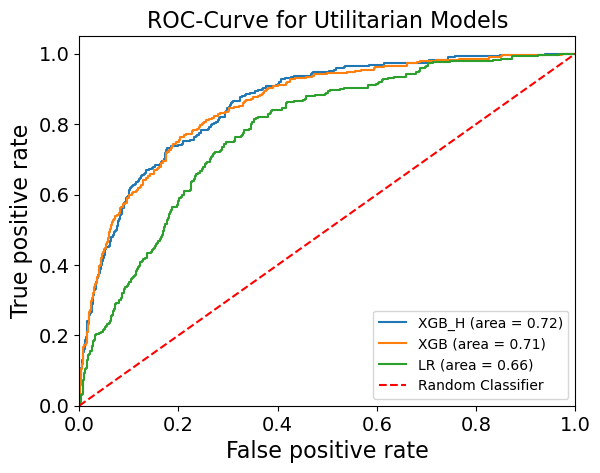

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate ROC AUC and curves for xgb_cls_hyp
logit_roc_auc_hyp = roc_auc_score(y_test, xgb_cls_hyp.predict(X_test))
fpr_hyp, tpr_hyp, thresholds_hyp = roc_curve(y_test, xgb_cls_hyp.predict_proba(X_test)[:,1])

# Calculate ROC AUC and curves for logreg_model
logit_roc_auc_logreg = roc_auc_score(y_test, logreg_model.predict(X_test))
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_model.predict_proba(X_test)[:,1])

# Calculate ROC AUC and curves for xgb_cls_SMOTE
logit_roc_auc_smote = roc_auc_score(y_test, xgb_cls_SMOTE.predict(X_test))
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, xgb_cls_SMOTE.predict_proba(X_test)[:,1])

# Plotting the ROC curves
plt.figure()
plt.plot(fpr_hyp, tpr_hyp, label='XGB_H (area = %0.2f)' % logit_roc_auc_hyp)
plt.plot(fpr_smote, tpr_smote, label='XGB (area = %0.2f)' % logit_roc_auc_smote)
plt.plot(fpr_logreg, tpr_logreg, label='LR (area = %0.2f)' % logit_roc_auc_logreg)
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier ')

# Setting plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase major tick label size
plt.tick_params(axis='both', which='minor', labelsize=14)  # Increase minor tick label size
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('ROC-Curve for Utilitarian Models', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('combined_ROC_Utilitarian',dpi=400)
plt.show()

# 4. Model Comparision

In [17]:
results = pd.concat([LR_results, XGB_Default_results, XGB_results, XGB_Hyp_results], axis=0)
print(results)

                          Model  Accuracy  F1 Score       AUC
0           Logistic Regression  0.777961  0.416787  0.664014
0               XGBoost Default  0.867218  0.488323  0.676637
0                 XGBoost SMOTE  0.866667  0.531008  0.707027
0  XGBoost with Hyperparameters  0.857851  0.534296  0.717140




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



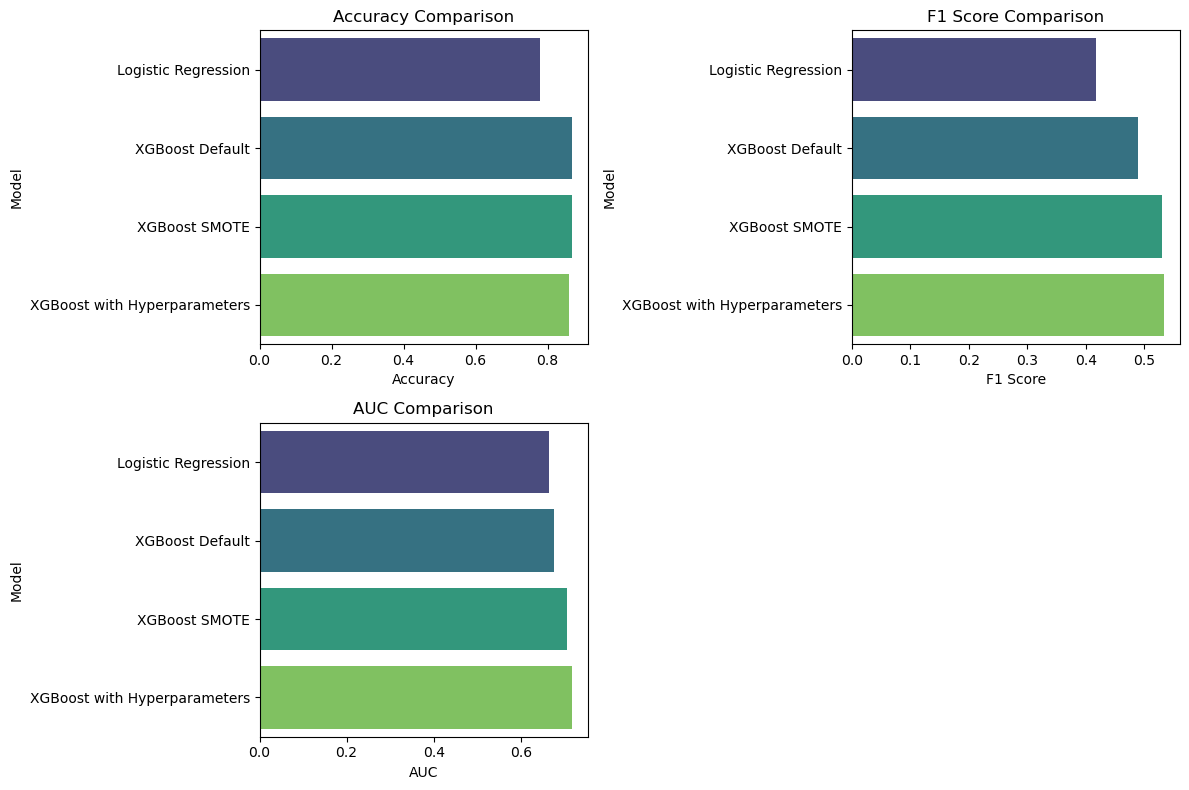

In [18]:
# Plotting the comparison
plt.figure(figsize=(12, 8))

# Plot 1: Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Accuracy', y='Model', data=results, palette='viridis')
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')

# Plot 2: F1 Score
plt.subplot(2, 2, 2)
sns.barplot(x='F1 Score', y='Model', data=results, palette='viridis')
plt.title('F1 Score Comparison')
plt.xlabel('F1 Score')

# Plot 3: AUC
plt.subplot(2, 2, 3)
sns.barplot(x='AUC', y='Model', data=results, palette='viridis')
plt.title('AUC Comparison')
plt.xlabel('AUC')

plt.tight_layout()
plt.show()

# 5. Feature Importance with Shap Values

[13:36:46] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 21663/21736 [00:26<00:00]        

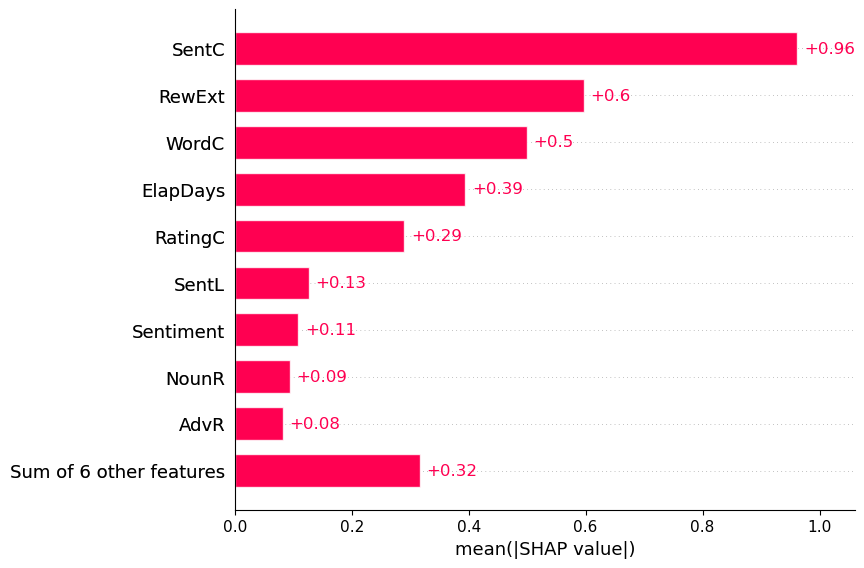

In [19]:
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.bar(shap_values.abs.mean(0))

[13:37:12] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 21708/21736 [00:25<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


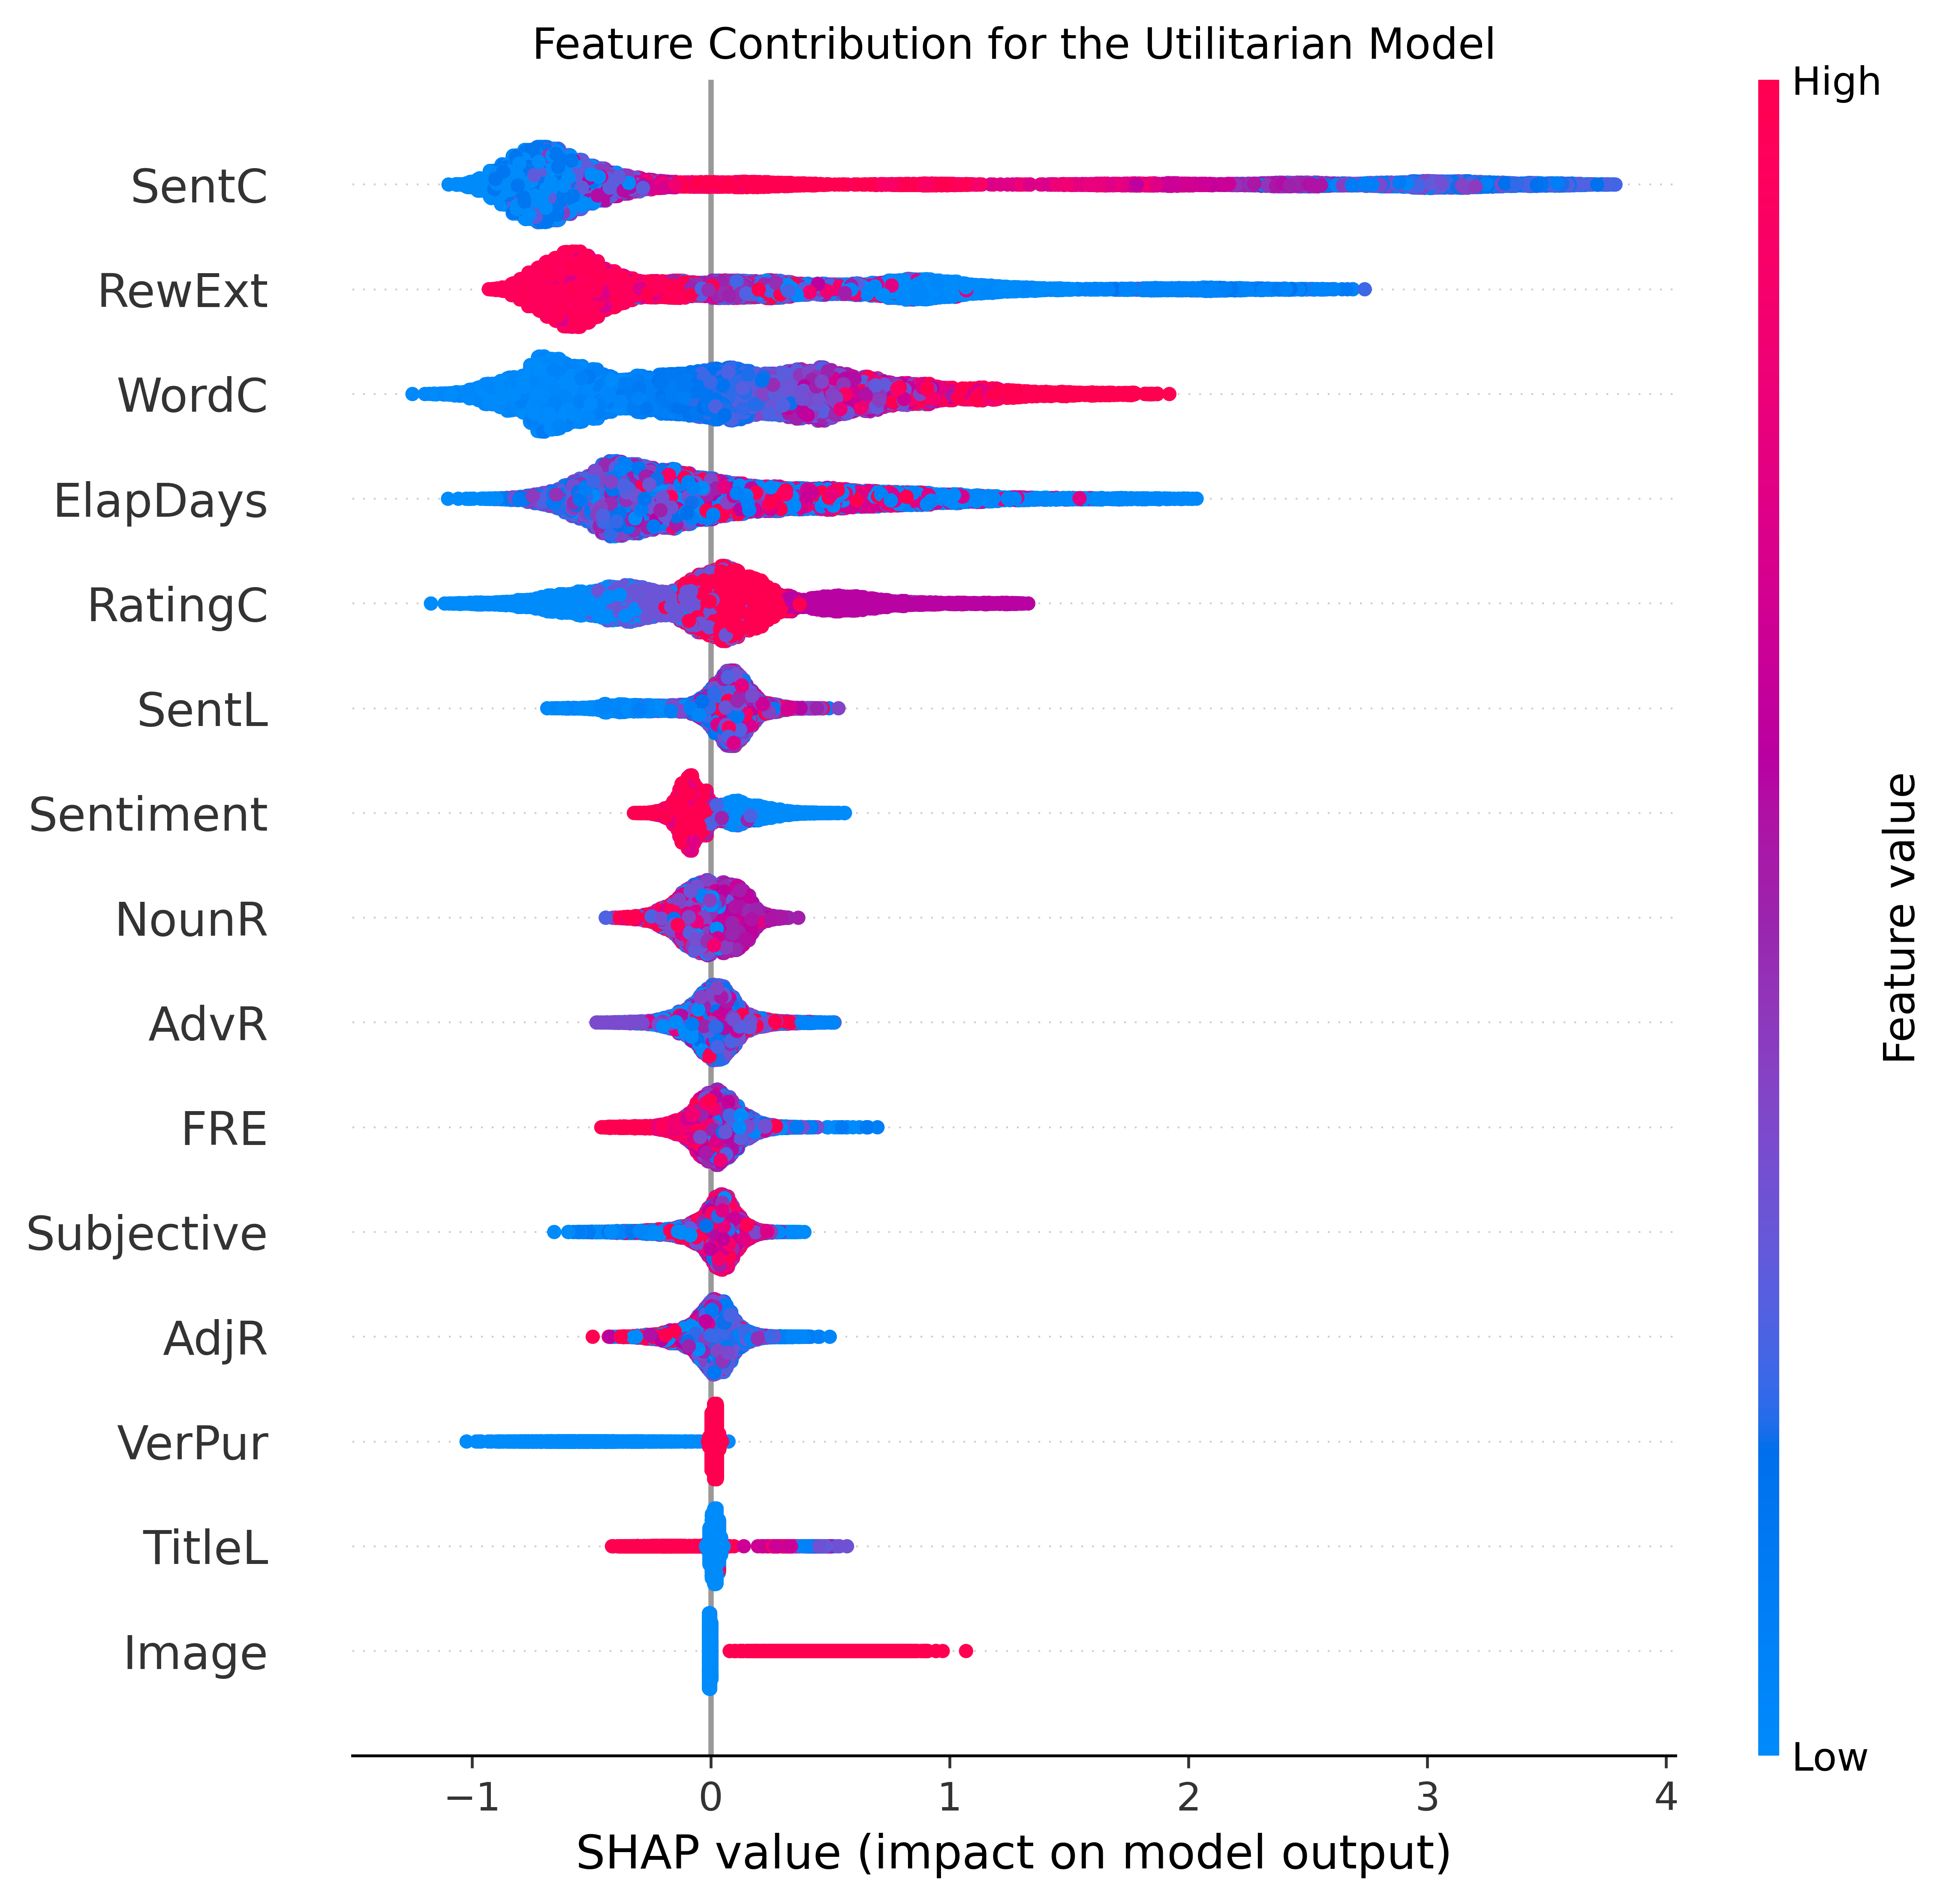

In [20]:
# Compute SHAP values
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

# Create a beeswarm plot with increased quality
fig, ax = plt.subplots(figsize=(6, 8), dpi=600)  # Set figure size and DPI
shap.plots.beeswarm(shap_values, max_display=15,show=False)  # Create the plot without displaying it immediately

# Add title to the plot
plt.title('Feature Contribution for the Utilitarian Model')

plt.tight_layout()  # Adjust the layout to prevent clipping

# Save the plot to a file with high resolution
#plt.savefig('shap_beeswarm_plot_Utilitarian.png', dpi=600)  # Save the figure with the desired DPI

# Display the plot
plt.show()

[13:45:50] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 21306/21736 [00:23<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


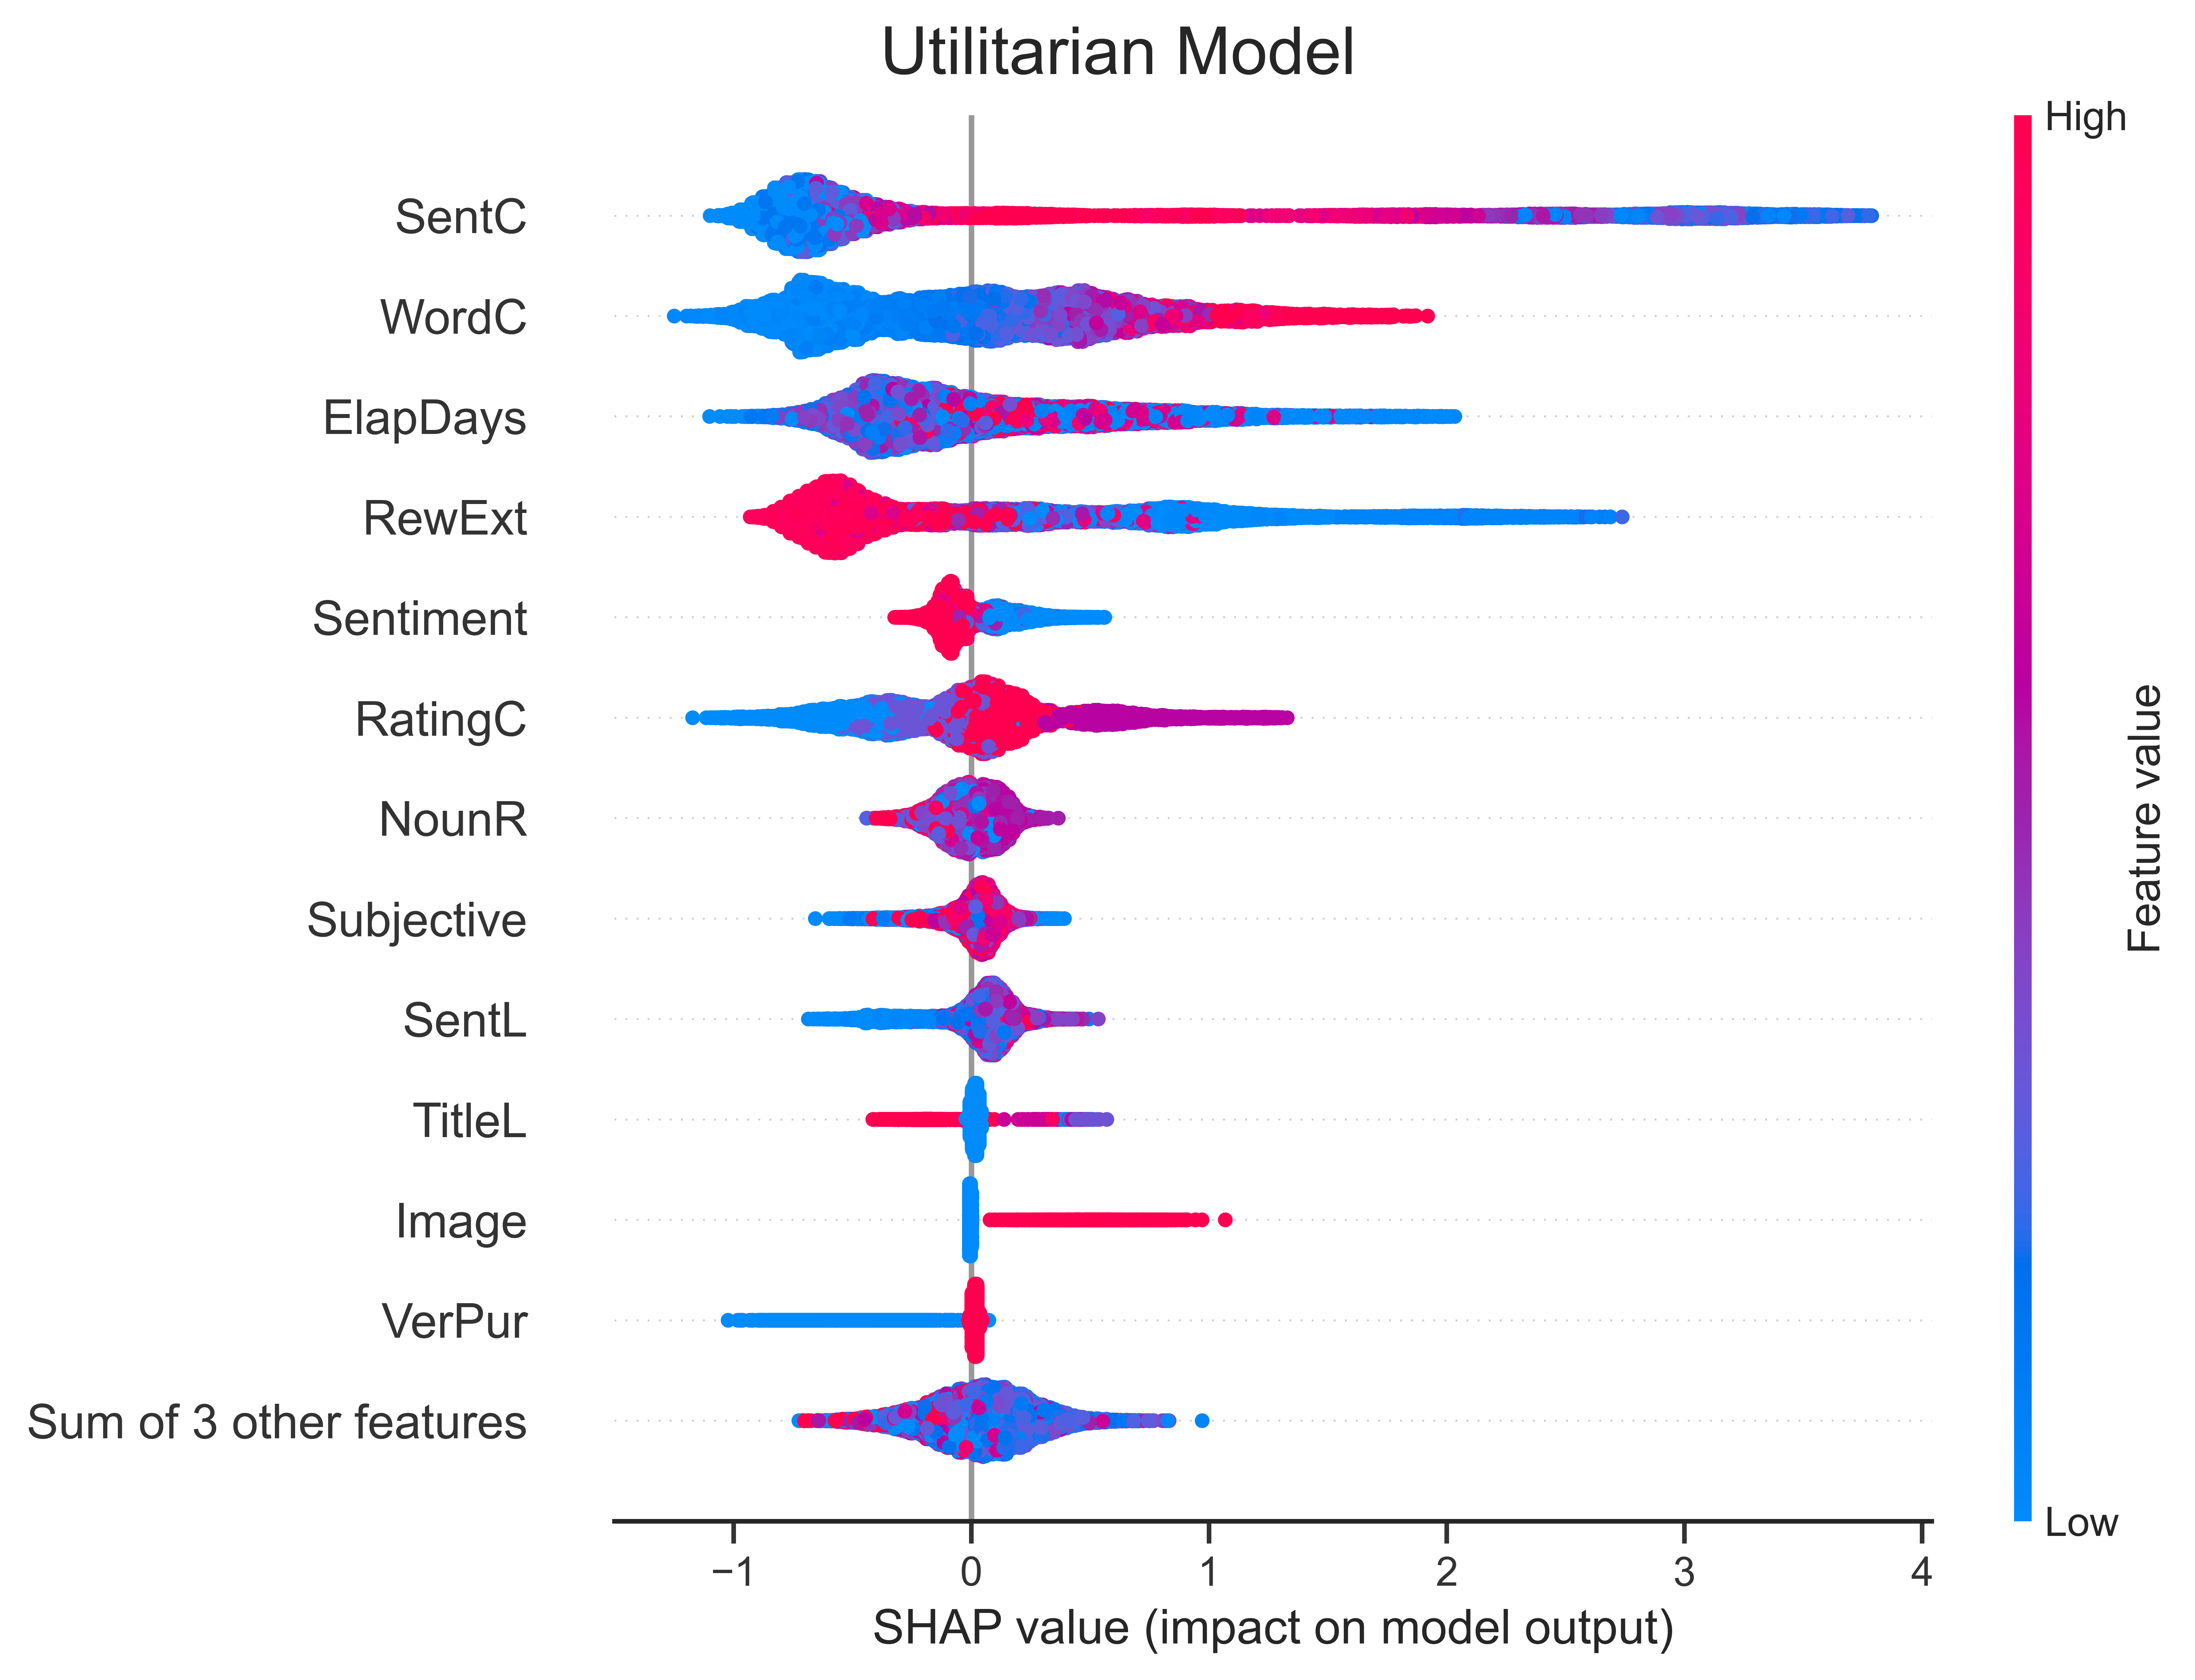

In [31]:
sns.set(style='white')

explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

# Define the order of the features
order = ['SentC','WordC','ElapDays','RewExt','Sentiment','RatingC','NounR','Subjective', 
         'SentL','TitleL', 'Image', 'VerPur', 'AdjR', 'AdvR', 'FRE',]

# Create a mapping from column names to their indices
col2num = {col: i for i, col in enumerate(X_train_balanced.columns)}

# Ensure all columns in order exist in the DataFrame and map them to their indices
order = [col2num[col] for col in order if col in col2num]

# Create the beeswarm plot with the correct order
fig, ax = plt.subplots(figsize=(12, 8), dpi=800)  # Set figure size and DPI
shap.plots.beeswarm(shap_values,  max_display=13, show=False, order=order) 


# Add the title above the plot with indentation
plt.suptitle('Utilitarian Model', fontsize=18, ha='left',  x=0.25, y=0.95)  

# Adjust the layout to create more space at the top for the title
plt.subplots_adjust(top=0.9) 

# Save the plot to a file with high resolution
plt.savefig('shap_beeswarm_plot_Utilitarian.png', dpi=600, bbox_inches = "tight")  
plt.show()

In [22]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

[13:37:49] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


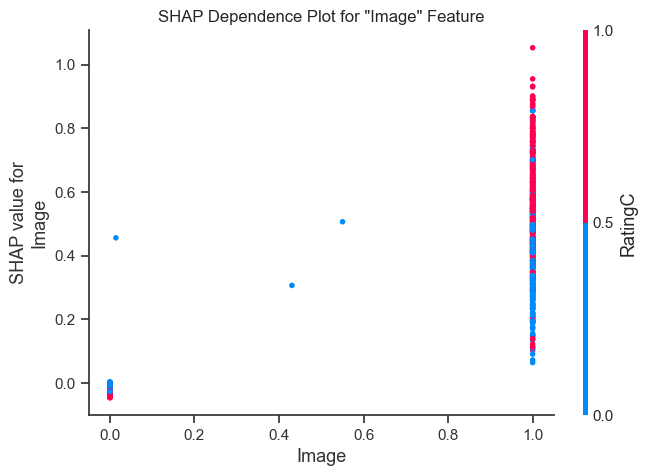

In [23]:
# Plot SHAP dependence plot for 'Image'
shap.dependence_plot('Image', shap_values, X_train_balanced, show=False)
plt.title('SHAP Dependence Plot for "Image" Feature')
plt.savefig('shap_dependence_plot_Image.png', dpi=300)
plt.show()

In [24]:
# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_df_train_sorted = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_df_train_sorted)

      features  average_shap_value
4        SentC            0.958600
0       RewExt            0.635061
3        WordC            0.516419
7     ElapDays            0.405763
14     RatingC            0.261127
1    Sentiment            0.122001
5        SentL            0.106281
10       NounR            0.092356
13         FRE            0.081195
12        AdvR            0.078224
2   Subjective            0.076092
11        AdjR            0.062238
9       VerPur            0.047590
8        Image            0.037143
6       TitleL            0.015371


In [25]:
shap_df_train_sorted.to_csv('/Users/paulahofmann/Documents/Coding/Online-Review/Models/shap_values_Utilitarian.csv', index=False)

[13:37:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


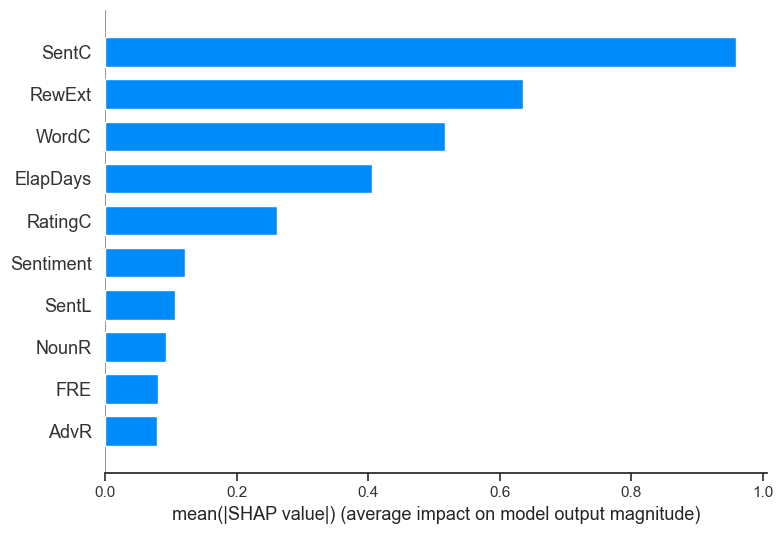

In [26]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Plot the SHAP summary plot with beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=True, max_display=10)



# 6. Testing on other Product


In [27]:
razor = pd.read_csv('/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Old Data/UtiliRazor.csv')

# Create a new column 'helpful' based on reviews being helfpul or not helpful
razor['helpful'] = (razor['helpful_vote'] > 0).astype(int)

In [28]:
# Define features and target
features = ['RewExt','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
                      'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE']
target = 'helpful'



# Initialize X and y
X_razor = razor[features]
y_razor = razor[target]

# Initialize ColumnTransformer for scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), features)  # Scale numerical features
    ],
    remainder='passthrough'  # Keep all other columns in the DataFrame
)

# Fit and transform the data
X_razor_preprocessed = preprocessor.fit_transform(X_razor)

# Convert the transformed data back to a DataFrame
X_razor = pd.DataFrame(X_razor_preprocessed, columns=features)


In [29]:
# Perform train/test split
XR_train, XR_test, yR_train, yR_test = train_test_split(X_razor, y_razor, test_size=0.2, random_state=42)


In [30]:
# Predictions on test data
Ra_y_pred_opt = xgb_cls_default.predict(XR_test)

# Model evaluation
accuracy = accuracy_score(yR_test, Ra_y_pred_opt)
conf_matrix = confusion_matrix(yR_test, Ra_y_pred_opt)
cls_report = classification_report(yR_test, Ra_y_pred_opt)

print("\nSMOTE-Hyp Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(yR_test, Ra_y_pred_opt)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(yR_test, Ra_y_pred_opt)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)


ValueError: feature_names mismatch: ['RewExt', 'Sentiment', 'Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays', 'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE', 'RatingC'] ['RewExt', 'Sentiment', 'Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays', 'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE']
expected RatingC in input data